In [1]:
import os
import sys
sys.path.append("/data/horse/ws/lama722b-nanite-lm/nanite-lm")
from pprint import pprint as print
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import AdamW, lr_scheduler
from xformers.ops import fmha, AttentionBias
from torch.nn.attention.flex_attention import (
    BlockMask,
    flex_attention,
    _mask_mod_signature,
)
from enum import Enum
from typing import Optional, Union, Tuple

In [2]:
from codebase.transformer import (
    BaseTransformerArgs,
    BaseTransformer,
    TransformerBlock,
    Attention,
    FeedForward,
    flex_attention_comp,
    RMSNorm,
    cross_entropy,
    apply_rotary_emb,
    reshape_for_broadcast,
    repeat_kv,
    InitStdFactor,
)
from codebase.optim import (
    OptimArgs,
    build_lr_fn
)

In [3]:
def create_causal_mask(seqlen, attn_impl, sliding_window):
    if sliding_window is not None and attn_impl == "fmha":
        return fmha.attn_bias.LocalAttentionFromBottomRightMask(
            window_left=sliding_window - 1, window_right=0
        )
    elif attn_impl == "fmha":
        return fmha.attn_bias.LowerTriangularMask()
    elif attn_impl == "sdpa":
        return "causal"
    elif attn_impl == "flex_attention":
        return create_block_mask(causal_mask, None, None, seqlen, seqlen)
    else:
        raise NotImplementedError(
            f"Attention {attn_impl} with {sliding_window} sliding window not implemented"
        )

## Mup Enabled Attention Layer

In [21]:
class MupAttention(Attention):
    def __init__(
        self,
        dim: int,
        head_dim: int,
        n_heads: int,
        n_kv_heads: int,
        rope_theta: float,
        scaling_factor: float,
    ):
        super().__init__(
            dim,
            head_dim,
            n_heads,
            n_kv_heads,
            rope_theta,
        )
        self.scaling_factor = scaling_factor
        
    def forward(
        self,
        x: torch.Tensor,
        freq_cis: torch.Tensor,
        tok_idx: Optional[torch.Tensor] = None,
        mask: Optional[Union[BlockMask, AttentionBias, str]] = None,
        attn_impl: str = "sdpa",
    ):
        # B S D
        bsz, seq_len, dim = x.shape
        xq = self.wq(x.view_as(x))
        xk = self.wk(x.view_as(x))
        xv = self.wv(x.view_as(x))

        output_shape = xq.shape
        # B S D -> B S H D
        xq = xq.view(bsz, seq_len, self.n_heads, self.head_dim)
        xk = xk.view(bsz, seq_len, self.n_kv_heads, self.head_dim)
        xv = xv.view(bsz, seq_len, self.n_kv_heads, self.head_dim)

        xq, xk = apply_rotary_emb(xq, xk, 1, freq_cis[0:seq_len])

        # This condition helps us be easily compatible
        # with inference by adding a pluggable KVCache
        if hasattr(self, "kv_cache"):
            xk, xv = self.kv_cache.update(xk, xv, tok_idx)

        xk = repeat_kv(xk, self.heads_per_group, dim=2)
        xv = repeat_kv(xv, self.heads_per_group, dim=2)

        attention_scaling_factor = 1.0 / self.n_heads

        if attn_impl == "flex_attention":
            assert mask is None or isinstance(mask, BlockMask)
            xq, xk, xv = map(lambda e: e.transpose(1, 2), (xq, xk, xv))
            output = flex_attention_comp(xq, xk, xv, block_mask=mask, scale=attention_scaling_factor)
            output = output.transpose(1, 2).contiguous()  # B H S D -> B S H D

        elif attn_impl == "fmha":
            assert mask is None or isinstance(mask, AttentionBias)
            output = fmha.memory_efficient_attention(xq, xk, xv, attn_bias=mask, scale=attention_scaling_factor)
            # This uses B S H D instead of B H S D of pytorch

        elif attn_impl == "sdpa":
            xq, xk, xv = map(lambda e: e.transpose(1, 2), (xq, xk, xv))
            assert mask is None or isinstance(mask, (str, torch.Tensor))
            is_causal = (mask == "causal") if isinstance(mask, str) else False
            mask = mask if isinstance(mask, torch.Tensor) else None
            output = F.scaled_dot_product_attention(
                xq,
                xk,
                xv,
                is_causal=is_causal,
                attn_mask=mask,
                scale=attention_scaling_factor
            )
            output = output.transpose(1, 2).contiguous()  # B H S D -> B S H D
        else:
            raise NotImplementedError(
                f"Attention implementation {attn_impl} not supported"
            )

        output = self.wo(output.reshape(output_shape))

        return output

    def reset_parameters(self, init_std=None, out_proj_factor=1.0):
        init_std = init_std or (self.dim ** (-0.5))

        for w in [self.wq, self.wk, self.wv]:
            nn.init.trunc_normal_(
                w.weight,
                mean=0.0,
                std=init_std / math.sqrt(self.scaling_factor),
                a=-3 * init_std,
                b=3 * init_std,
            )

        nn.init.trunc_normal_(
            self.wo.weight,
            mean=0.0,
            std=init_std / out_proj_factor,
            a=-3 * init_std,
            b=3 * init_std,
        )

class MupFeedForward(FeedForward):
    def __init__(
        self,
        dim,
        hidden_dim,
        multiple_of,
        ffn_dim_multiplier,
        scaling_factor: float = 1.0,
        mp_size: int = 1,
    ):
        super().__init__(
            dim=dim,
            hidden_dim=hidden_dim,
            multiple_of=multiple_of,
            ffn_dim_multiplier=ffn_dim_multiplier,
            mp_size = mp_size,
        )
        self.scaling_factor = scaling_factor

    def reset_parameters(
        self,
        init_std=None,
        factor=1.0,
    ):
        in_init_std = init_std or (self.dim ** (-0.5))
        out_init_std = init_std or (self.hidden_dim ** (-0.5))
        in_init_std = in_init_std / math.sqrt(self.scaling_factor)
        out_init_std = out_init_std / factor
        for w in [self.w1, self.w3]:
            nn.init.trunc_normal_(
                w.weight,
                mean=0.0,
                std=in_init_std,
                a=-3 * in_init_std,
                b=3 * in_init_std,
            )
        nn.init.trunc_normal_(
            self.w2.weight,
            mean=0.0,
            std=out_init_std,
            a=-3 * out_init_std,
            b=3 * out_init_std,
        )
        

In [22]:
class MupTransformerBlock(TransformerBlock):
    def __init__(self, args):
        super().__init__(args)
        self.scaling_factor = args.scaling_factor
        self.attention = MupAttention(
            dim = args.dim,
            head_dim = self.head_dim,
            n_heads = self.n_heads,
            n_kv_heads = self.n_kv_heads,
            rope_theta = args.rope_theta,
            scaling_factor = self.scaling_factor
        )
        self.feed_forward = MupFeedForward(
            dim=args.dim,
            hidden_dim=4*args.dim,
            multiple_of=args.multiple_of,
            ffn_dim_multiplier=args.ffn_dim_multiplier,
            scaling_factor=args.scaling_factor
        )

In [37]:
class MupTransformerArgs(BaseTransformerArgs):
    seed = 42
    vocab_size = -1
    weight_tying = False
    sliding_window = None
    input_alpha = 1.0
    output_alpha = 1.0
    scaling_factor: float = None

class MupOptimArgs(OptimArgs):
    scaling_factor: float = None


class MupTransformer(BaseTransformer):
    def __init__(
        self,
        args,
    ):
        super().__init__(args)
        self.input_alpha = args.input_alpha
        self.output_alpha = args.output_alpha
        self.weight_tying = args.weight_tying
        self.sliding_window = args.sliding_window
        self.scaling_factor = args.scaling_factor
        

        assert args.vocab_size > 0
        assert args.scaling_factor >= 1, "You need to set this!!!"

        self.tok_embeddings = torch.nn.Embedding(args.vocab_size, args.dim)
        # This is Post-Layer Norm layer or Post-Norm
        self.norm = RMSNorm(args.dim, eps=args.norm_eps)

        if args.weight_tying:
            self.output = TiedLinear(self.tok_embeddings)
        else:
            self.output = nn.Linear(
                args.dim,
                args.vocab_size,
                bias=False
            )
        self.layers = nn.ModuleList()
        for _ in range(args.n_layers):
            self.layers.append(MupTransformerBlock(args))

    def forward(
        self,
        token_values: torch.Tensor,
        target = None,
        tok_idx = None,
        mask = None,
        attn_impl = "sdpa",
    ):
        bsz, seqlen = token_values.shape
        mask = (
            mask
            if mask is not None
            else create_causal_mask(seqlen, attn_impl, self.sliding_window)
        )
        # (krotonus) NOTE: Embedding FWD MUP
        h = self.input_alpha * self.tok_embeddings(token_values)

        freq_cis = self.rope_embeddings(seqlen=self.max_seqlen, tok_idx=tok_idx)

        for i, layer in enumerate(self.layers):
            h = layer(h, freq_cis, tok_idx=tok_idx, mask=mask, attn_impl=attn_impl)

        # (krotonus) NOTE: Output Logit FWD. MUP
        logits = (self.output(self.norm(h)) * self.output_alpha) / self.scaling_factor
        if target is not None:
            return cross_entropy(logits, target)
        else:
            return logits

    def init_weights(self):
        self.reset_parameters()
        out_proj_factor =  math.sqrt(2 * args.n_layers * args.scaling_factor)
        for depth, layer in enumerate(self.layers):
            layer.init_weights(self.init_base_std, out_proj_factor)

In [48]:
inp = torch.randint(low=0, high=256, size=(1, 10))

args = MupTransformerArgs()
args.n_heads = 4
args.n_layers = 2
args.dim = 128
args.max_seqlen = 128
args.vocab_size = 256
args.scaling_factor = 1.0
print(args)
print("-"*100)
optim_args = MupOptimArgs()
optim_args.scaling_factor = 1.0
model = MupTransformer(args)
print(model)

MupTransformerArgs(dim=128,
                   n_layers=2,
                   head_dim=None,
                   n_heads=4,
                   n_kv_heads=None,
                   ffn_dim_multiplier=None,
                   multiple_of=256,
                   norm_eps=1e-05,
                   rope_theta=10000.0,
                   init_base_std=None,
                   init_std_factor='disabled',
                   max_seqlen=128)
'----------------------------------------------------------------------------------------------------'
MupTransformer(
  (rope_embeddings): RotaryEmbedding()
  (layers): ModuleList(
    (0-1): 2 x MupTransformerBlock(
      (attention): MupAttention(
        (wq): Linear(in_features=128, out_features=128, bias=False)
        (wk): Linear(in_features=128, out_features=128, bias=False)
        (wv): Linear(in_features=128, out_features=128, bias=False)
        (wo): Linear(in_features=128, out_features=128, bias=False)
      )
      (feed_forward): MupFeedForwar

In [28]:
model.init_weights()

In [29]:
inp.size(), inp.shape

(torch.Size([1, 10]), torch.Size([1, 10]))

In [30]:
model(inp)

tensor([[[-2.1746e-01,  3.7759e-02, -4.3266e-04,  ..., -3.6871e-01,
           8.3709e-01, -1.3619e-01],
         [ 4.0747e-01,  2.7429e-01, -7.2218e-01,  ...,  9.1531e-01,
           6.4633e-01, -1.0130e+00],
         [ 4.1656e-01,  3.1421e-01, -4.0535e-01,  ..., -1.5261e-01,
           1.6991e-01, -5.8452e-01],
         ...,
         [-2.8328e-01, -2.4091e-01,  5.4915e-01,  ...,  1.3069e+00,
           4.3992e-01, -5.0319e-01],
         [-2.3307e-01,  9.5362e-01, -1.7055e-01,  ...,  8.9563e-02,
          -7.0343e-01,  3.6659e-01],
         [ 3.4711e-01,  4.3249e-01, -9.6958e-01,  ...,  8.5858e-01,
           1.9173e+00, -2.0373e-01]]], grad_fn=<DivBackward0>)

In [31]:
for name, param in model.named_parameters():
    print(f"{name} : {param.shape}")

'layers.0.attention.wq.weight : torch.Size([128, 128])'
'layers.0.attention.wk.weight : torch.Size([128, 128])'
'layers.0.attention.wv.weight : torch.Size([128, 128])'
'layers.0.attention.wo.weight : torch.Size([128, 128])'
'layers.0.feed_forward.w1.weight : torch.Size([512, 128])'
'layers.0.feed_forward.w3.weight : torch.Size([512, 128])'
'layers.0.feed_forward.w2.weight : torch.Size([128, 512])'
'layers.0.attention_norm.weight : torch.Size([128])'
'layers.0.ffn_norm.weight : torch.Size([128])'
'layers.1.attention.wq.weight : torch.Size([128, 128])'
'layers.1.attention.wk.weight : torch.Size([128, 128])'
'layers.1.attention.wv.weight : torch.Size([128, 128])'
'layers.1.attention.wo.weight : torch.Size([128, 128])'
'layers.1.feed_forward.w1.weight : torch.Size([512, 128])'
'layers.1.feed_forward.w3.weight : torch.Size([512, 128])'
'layers.1.feed_forward.w2.weight : torch.Size([128, 512])'
'layers.1.attention_norm.weight : torch.Size([128])'
'layers.1.ffn_norm.weight : torch.Size([128])

### Optimizer Configuration

In [60]:
def build_mup_optimizer(
    model: nn.Module,
    args: OptimArgs,
    n_steps: int,
):
    mup_decay_params = []
    decay_params = []
    nodecay_params = []
    for n, p in model.named_parameters():
        if p.dim() >= 2:
            if (
            n.endswith('wq.weight') or
            n.endswith('wk.weight') or
            n.endswith('wv.weight') or
            n.endswith('wo.weight') or
            n.endswith('w1.weight') or
            n.endswith('w2.weight') or
            n.endswith('w3.weight')
            ):
                print(f"Added {n} to mup_decay_list")
                mup_decay_params.append(p)
            else:
                decay_params.append(p)
        else:
            nodecay_params.append(p)
    optim_groups = [
        {'params': mup_decay_params, 'weight_decay': args.weight_decay, 'lr_scale': (1/args.scaling_factor)},
        {'params': decay_params, 'weight_decay': args.weight_decay, 'lr_scale': 1},
        {'params': nodecay_params, 'weight_decay': 0.0, 'lr_scale': 1}
    ]
    num_mup_decay_params = sum(p.numel() for p in mup_decay_params)
    num_decay_params = sum(p.numel() for p in decay_params)
    num_nodecay_params = sum(p.numel() for p in nodecay_params)
    print(f"num mup decayed parameter tensors: {len(mup_decay_params)}, with {num_mup_decay_params:,} parameters")
    print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
    print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")

    optimizer = AdamW(
        optim_groups,
        lr=args.lr,
        betas=(args.beta1, args.beta2),
        eps=args.epsilon,
        fused=True,  # Faster optim.step but can throw errors
    )

    # scheduler
    lr_fn = build_lr_fn(args, n_steps)
    scheduler = lr_scheduler.LambdaLR(
        optimizer, lr_fn
    )  # lr_scheduler.LambdaLR(optimizer, lr_fn)

    return optimizer, scheduler

In [61]:
optimizer, scheduler = build_mup_optimizer(model, optim_args, 10)

'Added layers.0.attention.wq.weight to mup_decay_list'
'Added layers.0.attention.wk.weight to mup_decay_list'
'Added layers.0.attention.wv.weight to mup_decay_list'
'Added layers.0.attention.wo.weight to mup_decay_list'
'Added layers.0.feed_forward.w1.weight to mup_decay_list'
'Added layers.0.feed_forward.w3.weight to mup_decay_list'
'Added layers.0.feed_forward.w2.weight to mup_decay_list'
'Added layers.1.attention.wq.weight to mup_decay_list'
'Added layers.1.attention.wk.weight to mup_decay_list'
'Added layers.1.attention.wv.weight to mup_decay_list'
'Added layers.1.attention.wo.weight to mup_decay_list'
'Added layers.1.feed_forward.w1.weight to mup_decay_list'
'Added layers.1.feed_forward.w3.weight to mup_decay_list'
'Added layers.1.feed_forward.w2.weight to mup_decay_list'
'num mup decayed parameter tensors: 14, with 524,288 parameters'
'num decayed parameter tensors: 2, with 65,536 parameters'
'num non-decayed parameter tensors: 5, with 640 parameters'


In [62]:
for name, module in model.named_modules():
    print(f"{name}")

''
'rope_embeddings'
'layers'
'layers.0'
'layers.0.attention'
'layers.0.attention.wq'
'layers.0.attention.wk'
'layers.0.attention.wv'
'layers.0.attention.wo'
'layers.0.feed_forward'
'layers.0.feed_forward.w1'
'layers.0.feed_forward.w3'
'layers.0.feed_forward.w2'
'layers.0.attention_norm'
'layers.0.ffn_norm'
'layers.1'
'layers.1.attention'
'layers.1.attention.wq'
'layers.1.attention.wk'
'layers.1.attention.wv'
'layers.1.attention.wo'
'layers.1.feed_forward'
'layers.1.feed_forward.w1'
'layers.1.feed_forward.w3'
'layers.1.feed_forward.w2'
'layers.1.attention_norm'
'layers.1.ffn_norm'
'tok_embeddings'
'norm'
'output'


## Mup Coord Checking Exploration

In [3]:
from experiments.mup.transformer import (
    MupTransformerArgs,
    MupTransformer
)
from codebase.data import (
    DataArgs,
    build_dataloader_from_args,
    init_dataloader_state_from_args
)
from codebase.tokenizer import (
    build_tokenizer,
    TokenizerArgs
)
from functools import partial
from contextlib import ExitStack
from collections import defaultdict

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
tokenizer = build_tokenizer(
        name = "sp",
        path = "/home/lama722b/nanite_lm/tokenizers/gemma/tokenizer.model"
)
tok_args = TokenizerArgs(
    name = "sp",
    path = "/home/lama722b/nanite_lm/tokenizers/gemma/tokenizer.model"
)
data_args = DataArgs(
    root_dir = "/home/lama722b/nanite_lm/data/fineweb",
    sources = {
        "de_shuffled": 60.0,
        "en_shuffled": 40.0
    },
    batch_size = 1,
    seq_len=512,
    load_async = False,
    prefetch_size = 2,
    tokenizer = tok_args
)
tokenizer = build_tokenizer(name=tok_args.name, path=tok_args.path)
tokenizer.n_words
print(data_args)

DataArgs(root_dir='/home/lama722b/nanite_lm/data/fineweb',
         sources={'de_shuffled': 60.0, 'en_shuffled': 40.0},
         batch_size=1,
         seq_len=512,
         n_views=2,
         seed=42,
         add_bos=True,
         add_eos=True,
         load_async=False,
         prefetch_size=2,
         tokenizer=TokenizerArgs(name='sp',
                                 path='/home/lama722b/nanite_lm/tokenizers/gemma/tokenizer.model'))


In [5]:
def build_model_args(width):
    args = MupTransformerArgs()
    args.n_heads = 4
    args.n_layers = 2
    args.dim = width
    args.max_seqlen = 512
    args.vocab_size = tokenizer.n_words
    args.scaling_factor = 1.0
    return args

In [7]:
df = defaultdict(list)
for width in [256,512,1024]:
    args = build_model_args(width)
    model = MupTransformer(args)
    with ExitStack() as context_stack:
        data_loader_state = init_dataloader_state_from_args(
                data_args, rank=0, world_size=1 # Using dummy rank/degree for non-distributed
            )
        data_loader = context_stack.enter_context(
                    build_dataloader_from_args(
                        data_args,
                        state=data_loader_state,
                    )
                )
        model.train()
        coord_check_dict = {
                    'token_embedding': [],
                    'attn': [],
                    'mlp': [],
                    'lm_head': [],
                }
        def hook(module, input, output, key):
            # from ipdb import set_trace; set_trace()
            # print(f"In layer {module._get_name()}, Input shape: {input[0].shape}, Output shape: {output[0].shape}")
            with torch.no_grad():
                coord_check_dict[key].append(output.abs().mean().item())
        coord_check_handles = []
        for module_name, module in model.named_modules():
            if module_name == 'tok_embeddings':
                print(f"Registering hook on: {module_name} for key 'token_embedding'")
                coord_check_handles.append(module.register_forward_hook(partial(hook, key='token_embedding')))
            elif module_name.endswith('.attention'):
                print(f"Registering hook on: {module_name} for key 'attn'")
                coord_check_handles.append(module.register_forward_hook(partial(hook, key='attn')))
            elif module_name.endswith('.feed_forward'):
                print(f"Registering hook on: {module_name} for key 'mlp'")
                coord_check_handles.append(module.register_forward_hook(partial(hook, key='mlp')))
            elif module_name == 'output':
                print(f"Registering hook on: {module_name} for key 'lm_head'")
                coord_check_handles.append(module.register_forward_hook(partial(hook, key='lm_head')))
            
        for n in range(5):
            print(f"Train step {n}")
            batch, _ = next(data_loader) # We don't need to update state externaly in this simple loop
            batch = torch.tensor(batch)
            input_ids = batch[:, :, 0]
            labels = batch[:, :, 1]
            output = model(input_ids, labels)
            
        for handle in coord_check_handles:
            handle.remove()
    df[str(width)].append(coord_check_dict)

"Registering hook on: layers.0.attention for key 'attn'"
"Registering hook on: layers.0.feed_forward for key 'mlp'"
"Registering hook on: layers.1.attention for key 'attn'"
"Registering hook on: layers.1.feed_forward for key 'mlp'"
"Registering hook on: tok_embeddings for key 'token_embedding'"
"Registering hook on: output for key 'lm_head'"
'Train step 0'
'Train step 1'
'Train step 2'
'Train step 3'
'Train step 4'
"Registering hook on: layers.0.attention for key 'attn'"
"Registering hook on: layers.0.feed_forward for key 'mlp'"
"Registering hook on: layers.1.attention for key 'attn'"
"Registering hook on: layers.1.feed_forward for key 'mlp'"
"Registering hook on: tok_embeddings for key 'token_embedding'"
"Registering hook on: output for key 'lm_head'"
'Train step 0'
'Train step 1'
'Train step 2'
'Train step 3'
'Train step 4'
"Registering hook on: layers.0.attention for key 'attn'"
"Registering hook on: layers.0.feed_forward for key 'mlp'"
"Registering hook on: layers.1.attention for k

In [20]:
assert 5 == len(df['256'][0]['token_embedding'])
assert 10 == len(df['256'][0]['mlp'])
assert 10 == len(df['256'][0]['attn'])
assert 5 == len(df['256'][0]['lm_head'])

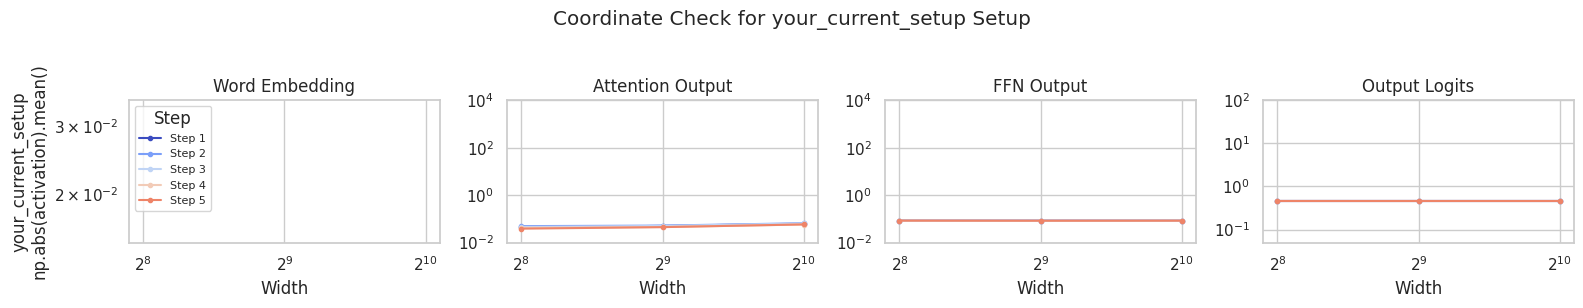

In [21]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm # Not strictly needed as you're not loading from disk
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
from collections import defaultdict # Need this for your df
from functools import partial # You used this in your original code, might need for context

sns.set(style='whitegrid')

# --- Start of user's df structure (assumed to be populated by your PyTorch script) ---
# This 'df' would be the output from your previous PyTorch script
# For demonstration, let's create a dummy 'df' with the structure you described
# In your actual use, this 'df' would already be populated by running your PyTorch code.

# Dummy data generation to simulate your 'df' from the PyTorch script
# (You would remove this section and use your actual 'df' object)
# from collections import defaultdict
# import torch
# import random
# df = defaultdict(list)
# for width in [256, 512, 1024]:
#     coord_check_dict = {
#         'token_embedding': [],
#         'attn': [], # Will have 2 values per step
#         'mlp': [], # Will have 2 values per step
#         'lm_head': [],
#     }
#     for _ in range(5): # 5 training steps
#         # Simulate activation magnitudes, roughly in expected ranges
#         coord_check_dict['token_embedding'].append(random.uniform(1.5e-2, 3.5e-2))
#         coord_check_dict['attn'].append(random.uniform(1e-2, 1e4)) # Layer 0 attn
#         coord_check_dict['attn'].append(random.uniform(1e-2, 1e4)) # Layer 1 attn
#         coord_check_dict['mlp'].append(random.uniform(1e-2, 1e4)) # Layer 0 mlp
#         coord_check_dict['mlp'].append(random.uniform(1e-2, 1e4)) # Layer 1 mlp
#         coord_check_dict['lm_head'].append(random.uniform(5e-2, 1e2))
#     df[str(width)].append(coord_check_dict)
# --- End of dummy data generation ---

# In your actual environment, ensure 'df' is available here after running your PyTorch code.
# For this adaptation, I will assume `df` is already populated with the data you showed.

class MplColorHelper:
    """Helper class for consistent color mapping."""
    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)

# Mapping from your 'coord_check_dict' keys to plot labels and expected ranges
# Note: The keys here must match the keys in your coord_check_dict
layer_types_mapping = [
    ('token_embedding', 'Word Embedding', (1.5e-2, 3.5e-2)),
    ('attn', 'Attention Output', (1e-2, 1e4)), # This will now represent an average or selected layer
    ('mlp', 'FFN Output', (1e-2, 1e4)),     # This will now represent an average or selected layer
    ('lm_head', 'Output Logits', (5e-2, 1e2)),
]

# Since your `df` is currently for one parameterization (the implicit one from your script)
# and for fixed seeds (you run 5 steps, but not across different seeds within the 'df' structure)
# we need to adjust how 'parameterizations' and 'seeds' are handled.
# For now, let's assume we're plotting a single 'parameterization' data that your 'df' represents.
# If you ran your PyTorch script multiple times for different parameterizations and stored them
# in a higher-level dictionary, that would be the place to loop.
# For simplicity, I'll treat your `df` as belonging to a single 'parameterization'.
parameterizations = ['your_current_setup'] # This is a placeholder. Adapt if you have multiple `df`s.
# If your `df` only contains data for one seed (the implicit one from running the code once),
# then 'seeds' should reflect that. Your current PyTorch code isn't looping over seeds,
# it's collecting 5 steps for a single run.
# So, 'seeds' here should refer to multiple *runs* of your data collection script,
# not multiple steps within one run. Let's assume you've run the script multiple times
# with different seeds and somehow aggregated the `df`s, or you're just showing one run's stats.
# Given your problem description, I'll assume `df` represents *one* seed's data for the 5 steps.
seeds = [1] # Assuming your `df` is the result of one run (one seed).
             # If you actually generate multiple `df`s for different seeds, you'd need
             # a higher-level structure like `all_dfs_by_seed = {seed: df_for_that_seed}`.
             # For now, we'll average over what *is* in your df, which is 5 steps.

widths = [256, 512, 1024] # These are the keys in your `df`

# t_max is the number of steps you recorded data for.
# Your PyTorch script runs for 5 steps.
t_max = 5 # Corrected to match your data collection script

color_helper = MplColorHelper('coolwarm', 0, t_max)

n_cols = len(layer_types_mapping)
n_rows = len(parameterizations) # Currently 1, adjust if you add more outer loops

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), squeeze=False)
# squeeze=False ensures axes is always 2D, even if n_rows or n_cols is 1.

# We need a new structure to hold the aggregated results for plotting
# {parameterization_idx: {layer_type_idx: {t: {width: [list_of_values_across_seeds_if_applicable]}}}}
# Since your current `df` represents a single run (implicitly a single seed) for each width,
# `results_matrix` will just store the single value for each step, width, and layer.
# We will effectively be plotting a single line per step, not averaging over seeds for now.
# If you expand your data collection to multiple seeds, this part would need to accumulate them.

# Let's create a structure to hold results that is easier to plot.
# We'll adapt it to the structure `(layer_type, t, width, seed_idx)`
# However, given your `df` structure, 'seed_idx' effectively becomes 'run_idx' here,
# and you only have one 'run_idx' for each width in your `df`.
# We need to reshape the `mlp` and `attn` data to have `t_max` entries.

# Initialize a dictionary to store processed data for plotting
processed_data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
# Structure: processed_data[parameterization_name][layer_type_name][width_val] = list_of_magnitudes_per_step

for width_idx, width in enumerate(widths):
    width_str = str(width) # Keys in your df are strings
    if width_str not in df:
        print(f"No data found for width {width_str}. Skipping.")
        continue

    # Your df[width_str] is a list, and you append one coord_check_dict to it per width.
    # So we take the first (and only) element.
    coord_data_for_width = df[width_str][0]

    for layer_key, layer_label, ylims in layer_types_mapping:
        raw_values = coord_data_for_width[layer_key]

        # This is the crucial part for handling multi-layer output
        per_step_values = []
        if layer_key in ['attn', 'mlp']:
            # Assuming 2 layers per block, so 2 values per step.
            # We need to average them to get one value per step.
            # Critique: Averaging here loses information about individual layer magnitudes.
            # If you want to see individual layer magnitudes, you would need
            # to modify your PyTorch hook to use distinct keys, e.g., 'attn_layer0', 'attn_layer1'.
            # For now, let's average.
            if len(raw_values) > 0: # Avoid division by zero if list is empty
                values_per_step = len(raw_values) // t_max
                for i in range(t_max):
                    # Take the average of 'values_per_step' items for this step
                    step_slice = raw_values[i * values_per_step : (i + 1) * values_per_step]
                    per_step_values.append(np.mean(step_slice))
            else:
                # Handle cases where no data was collected for this layer
                per_step_values = [np.nan] * t_max # Fill with NaNs
        else: # token_embedding, lm_head - assumed to have 1 value per step
            per_step_values = raw_values[:t_max]
            # Ensure it has exactly t_max elements, pad with NaN if less
            if len(per_step_values) < t_max:
                per_step_values = per_step_values + [np.nan] * (t_max - len(per_step_values))


        # Store the processed per-step values.
        # Since 'seeds' is effectively [1] and 'parameterizations' is ['your_current_setup'],
        # we're essentially storing a single data point per (layer, t, width).
        # We can store these directly for plotting.
        processed_data[parameterizations[0]][layer_key][width] = per_step_values


# Now, loop through the plotting logic, using processed_data
for parameterization_idx, parameterization in enumerate(parameterizations):
    for layer_type_idx, (layer_key, layer_type_str, ylims) in enumerate(layer_types_mapping):
        ax = axes[parameterization_idx, layer_type_idx]

        # We will plot one line per training step (t)
        for t in range(t_max):
            # Collect data points for this specific step 't' across all widths
            means_for_step_t = []
            widths_for_plotting = [] # To ensure we only plot for widths where data exists

            for width_idx, width in enumerate(widths):
                if width in processed_data[parameterization][layer_key]:
                    # Get the value for this step 't' from the processed_data list
                    # Note: We're not calculating mean/stderr over seeds here, as 'seeds' is effectively 1.
                    # This is plotting the direct value from your single run.
                    value_at_step_t = processed_data[parameterization][layer_key][width][t]
                    if not np.isnan(value_at_step_t): # Only add if not NaN
                        means_for_step_t.append(value_at_step_t)
                        widths_for_plotting.append(width)
                # If you expand to multiple seeds for a given (width, step, layer_key),
                # you would average across those seeds here and calculate standard errors.
                # For example:
                # all_values_for_step_t_width = [d[layer_key][t] for d in all_dfs_for_this_width_and_step_and_layer_across_seeds]
                # means_for_step_t.append(np.mean(all_values_for_step_t_width))
                # stderrs_for_step_t.append(np.std(all_values_for_step_t_width, ddof=1) / np.sqrt(len(all_values_for_step_t_width)))

            if means_for_step_t: # Only plot if there's data for this step
                ax.plot(widths_for_plotting, means_for_step_t,
                        label=f'Step {t+1}', color=color_helper.get_rgb(t), marker='.')
                # No fill_between for stderrs as we have only one "seed" (run) per width.
                # If you add multiple seeds/runs for the same width, you'd calculate stderrs.

        ax.set_title(layer_type_str)
        ax.set_xlabel('Width')
        # Only set ylabel for the first column of plots
        if layer_type_idx == 0:
            axes[parameterization_idx, 0].set_ylabel(f'{parameterization}\nnp.abs(activation).mean()') # Include param name for clarity
        
        # Only add legend to the first subplot of each row, or adjust as desired
        if layer_type_idx == 0: # or maybe just the top-left one: parameterization_idx == 0 and layer_type_idx == 0:
             ax.legend(loc='upper left', fontsize=8, title='Step')

        ax.set_xscale('log', base=2)
        ax.set_yscale('log')
        ax.set_ylim(*ylims)
        ax.tick_params(axis='x', which='minor', bottom=True) # Ensure minor ticks are visible for log scale


plt.suptitle(f'Coordinate Check for {parameterizations[0]} Setup', y=1.02) # Adjusted suptitle
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust rect to make space for suptitle
plt.show()
plt.close()